# Radial Basis Function Model

This section provides implementation for concepts related to radial basis function (RBF) models. In these models, a specific type of basis function is used which computes similarity between inputs and a set of reference points in the design space. Let $\mathbf{x}$ be the input vector, $\mathbf{c}_i$ be the $i^{th}$ reference point vector, and $r_i$ be the euclidean distance between $\mathbf{x}$ and $\mathbf{c}_i$ i.e. $|| \mathbf{x} - \mathbf{c}_i ||_2$. Then, the basis function vector will be:

$$
    \pmb{\psi} = [ \psi_1(r_1) \quad  \cdots \quad \psi_i(r_i) \quad \cdots \quad \psi_n(r_n)]^T
$$

The reference points are typically training points which implies that number of functions in basis vector will be equal to the number of training points. There are many possible options for $\psi_i(r_i)$ such as:

- Linear: $\psi_i(r_i) = r_i$
- Cubic: $\psi_i(r_i) = r_i^3$
- Thin-plate spline: $\psi_i(r_i) = r_i^2 \log(r_i)$
- Gaussian: $\psi_i(r_i) = \exp (- r_i^2/\sigma^2 )$
- Multiquadric: $\psi_i(r_i) = \sqrt{r_i^2 + \sigma^2}$
- Inverse Multiquadric: $\psi_i(r_i) = \frac{1}{\sqrt{r_i^2 + \sigma^2}}$

where $\sigma$ is a scaling factor. The radial basis function model is an interpolating model i.e. the model passes through all the data points. This is very useful when there is no noise in the data but will over-fit easily when there is noise in the data.

`scimlstudio` is used for creating RBF models, please refer to the [repository](https://github.com/ComputationalDesignLab/scimlstudio) for more details. The implementation in `scimlstudio` provides the option to use one of Gaussian, Multiquadric or Inverse Multiquadric basis functions.

> __*NOTE*__: Remember to make sure that you have the latest version of the `scimlstudio` package before running the code in this section.

In this notebook, the Forrester function (given below) will be used to demonstrate the RBF model. A similar function was also used in the previous section to demonstrate polynomial models. 

$$
y(x) = (6x - 2)^2\sin(12x-4) \\
0 \leq x \leq 1
$$

Below block of code imports the `torch` library and uses it to define this function:

In [10]:
import torch
forrester = lambda x: (6*x-2)**2*torch.sin(12*x-4)

Below block of code generates the training and testing data. After generating the data, the training data is plotted along with the true function values. 

Text(0, 0.5, 'y(x)')

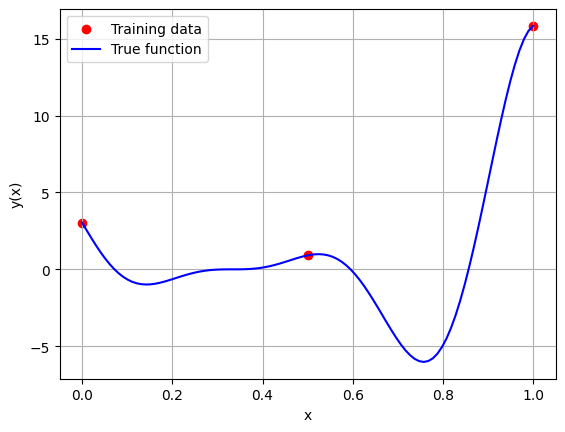

In [11]:
import matplotlib.pyplot as plt # importing to create plots

# Defining the device and data types
tkwargs = {"device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'), "dtype": torch.float64}

# Bounds
xlower = 0
xupper = 1

# Number of training and testing points
num_training_pts = 3
num_testing_pts = 100

# Generating training data
x_train = torch.linspace(xlower, xupper, num_training_pts, **tkwargs)
y_train = forrester(x_train)

# Generating testing data
x_test = torch.linspace(xlower, xupper, num_testing_pts, **tkwargs)
y_test = forrester(x_test)

# Plotting the training data and the true function
fig, ax = plt.subplots()
ax.scatter(x_train.numpy(), y_train.numpy(), c='r', label='Training data')
ax.plot(x_test.numpy(), y_test.numpy(), 'b', label='True function')
ax.grid()
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y(x)')

Now that we have generated the training and testing data, we can create and fit an `RBF` model on the training data. To do this, the `RBF` class must be imported from the `scimlstudio` package. Similar to the `Polynomial` class, there are three required arguments to initialize the class. 
* `x_train`: A 2D tensor array containing the training inputs with shape (N, d)
* `y_train`: A 2D tensor array containing the training outputs with shape (N, 1)
* `sigma`: Value of the `sigma` that will be used to calculate the basis functions

`N` refers to the number of training points and `d` refers to the dimensionality of the problem. In this case, we are using a 1D problem so `d=1`. Another important optional argument for initializing the `RBF` model is the `basis` argument. The `basis` argument specifies which basis function must be used for the model. The argument is a string which can be one of "gaussian", "multiquadric" and "inverse". These correspond to the Gaussian, Multiquadric and Inverse Multiquadric basis functions. 

Once the `RBF` model is initialized, the `fit` method is called to calculate the weights and basis matrix of the `RBF` model. After that, the `predict` method can be used to generate predictions for given inputs. Similar to the `Polynomial` model, the inputs must be a 2D tensor of shape (M, d) where `M` is the number of test points. 

The block of code below creates and fits a RBF model to the training data with different basis functions and $\sigma = 1$. The predictions from the models are plotted along with the true function using the testing data for the function. 

Gaussian Psi matrix: tensor([[1.0000e+00, 3.7267e-06, 1.9287e-22],
        [3.7267e-06, 1.0000e+00, 3.7267e-06],
        [1.9287e-22, 3.7267e-06, 1.0000e+00]], dtype=torch.float64)
Gaussian Weights: tensor([[ 3.0272],
        [ 0.9092],
        [15.8297]], dtype=torch.float64)
Multiquadric Psi matrix: tensor([[0.1000, 0.5099, 1.0050],
        [0.5099, 0.1000, 0.5099],
        [1.0050, 0.5099, 0.1000]], dtype=torch.float64)
Multiquadric Weights: tensor([[ 5.9031],
        [21.0266],
        [-8.2435]], dtype=torch.float64)
Inverse Multiquadric Psi matrix: tensor([[10.0000,  1.9612,  0.9950],
        [ 1.9612, 10.0000,  1.9612],
        [ 0.9950,  1.9612, 10.0000]], dtype=torch.float64)
Inverse Multiquadric Weights: tensor([[ 0.1937],
        [-0.2639],
        [ 1.6154]], dtype=torch.float64)


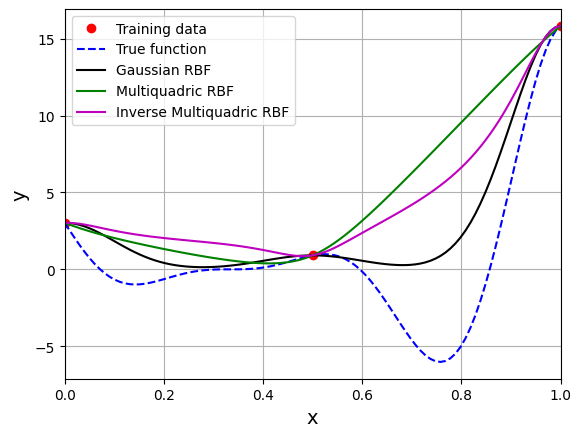

In [12]:
from scimlstudio.models.rbf import RBF # importing the RBF model

# Creating an RBF model with the gaussian basis function
rbf_gaussian = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=0.1, basis="gaussian")
gaussian_weights, gaussian_basis_matrix = rbf_gaussian.fit()
y_gaussian_pred = rbf_gaussian.predict(x_test.reshape(-1,1))

print(f"Gaussian Psi matrix: {gaussian_basis_matrix}")
print(f"Gaussian Weights: {gaussian_weights}")

# Creating an RBF model with the multiquadric basis function
rbf_mq = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=0.1, basis="multiquadric")
mq_weights, mq_basis_matrix = rbf_mq.fit()
y_mq_pred = rbf_mq.predict(x_test.reshape(-1,1))

print(f"Multiquadric Psi matrix: {mq_basis_matrix}")
print(f"Multiquadric Weights: {mq_weights}")

# Creating an RBF model with the inverse multiquadric basis function
rbf_imq = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=0.1, basis="inverse")
imq_weights, imq_basis_matrix = rbf_imq.fit()
y_imq_pred = rbf_imq.predict(x_test.reshape(-1,1))

print(f"Inverse Multiquadric Psi matrix: {imq_basis_matrix}")
print(f"Inverse Multiquadric Weights: {imq_weights}")

# Plotting
plt.plot(x_train, y_train, 'ro', label="Training data")
plt.plot(x_test, y_test, 'b--', label="True function")
plt.plot(x_test, y_gaussian_pred, 'k', label="Gaussian RBF")
plt.plot(x_test, y_mq_pred, 'g', label="Multiquadric RBF")
plt.plot(x_test, y_imq_pred, 'm', label="Inverse Multiquadric RBF")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.grid()
plt.show()

The $\Psi$ is a $3 \times 3$ symmetric matrix since there are three training points. Each diagonal element represents similarity of a training point with itself whereas off-diagonal elements represent similarity between two training points. For the gaussian RBF, the diagonal elements of the basis matrix are 1. `sigma` is a hyperparameter for the `RBF` model. The value of `sigma` can have a large effect on prediction accuracy and must be chosen carefully.

Below block of code defines a function to calculate the value of $\sigma$ using cross-validation. In this case, the cross-validation is demonstrated only for the gaussian RBF model. However, it can be applied to a RBF model with any other basis function as well. Read comments in the code for more details.

> __*NOTE*__: This method of cross-validation is slightly different from simple or k-fold cross validation described in previous section. There is no need to split training data into k-fold since testing data is already provided.

In [13]:
import numpy as np
from scimlstudio.utils.evaluation_metrics import evaluate_scalar # importing to calculate nrmse metric

def find_sigma(x_train, y_train, x_test, y_test, sigmas):
    """
    This function finds the best sigma for a RBF model by fitting the model to the training data and
    evaluating it on testing data. The best sigma is the one that achieves minimum normalized RMSE.

    Parameters
    ----------
    x_train : numpy array
        Training data x values
    y_train : numpy array
        Training data y values
    x_test : numpy array
        Testing data x values
    y_test : numpy array
        Testing data y values
    sigmas : numpy array
        Sigmas to be tested

    Returns
    -------
    best_sigma : float
        Best sigma value
    metric : list
        List of NRMSE values for each sigma
    """

    # Initializing normalized RMSE list
    metric = []

    # Fitting various polynomials
    for sigma in sigmas:

        # Fit the RBF to current fold
        rbf = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=sigma.item(), basis="gaussian")
        rbf_weights, basis_matrix = rbf.fit()

        # Predict at test values
        y_test_pred = rbf.predict(x_test.reshape(-1,1))

        # Calculating the nrmse of the values
        nrmse = evaluate_scalar(y_test, y_test_pred.reshape(-1,), metric="nrmse")
            
        # Calculating average nrmse
        metric.append(nrmse)

    best_sigma = sigmas[np.argmin(metric)]

    return best_sigma, metric

Below block of code uses above function to compute the best value of sigma.

Best sigma value found: 0.06135907396674156


Text(0.5, 1.0, 'Variation of NRMSE with $\\sigma$')

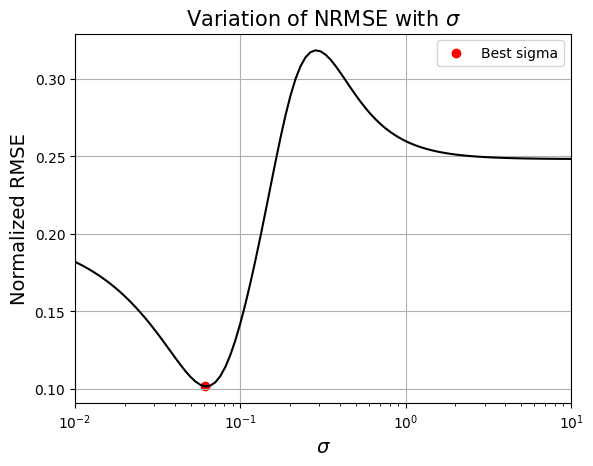

In [14]:
# Creating 1d numpy array which contains sigmas
# Note that it is logspace since values vary from 0.01 to 10
sigmas = torch.logspace(-2, 1, 100)

best_sigma, test_metric = find_sigma(x_train, y_train, x_test, y_test, sigmas)

print("Best sigma value found: {}".format(best_sigma))

# Plotting the NRMSE
plt.plot(sigmas, test_metric, 'k')
plt.scatter(best_sigma, min(test_metric), color='r', label="Best sigma")
plt.xlim((sigmas[0], sigmas[-1]))
plt.xlabel(r"$\sigma$", fontsize=14)
plt.ylabel("Normalized RMSE", fontsize=14)
plt.xscale("log")
plt.grid()
plt.legend()
plt.title(r"Variation of NRMSE with $\sigma$", fontsize=15)

Based on the plot, there a specific value of $\sigma$ for which the rmse is minimum. Next block of code fits RBF model for this value of $\sigma$ and plots the model prediction.

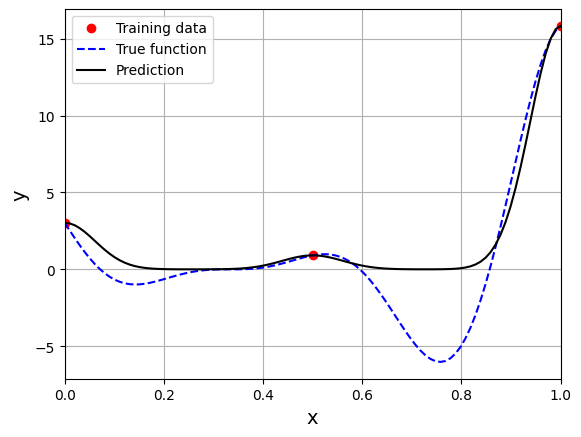

In [15]:
# Fitting the RBF with best sigma value
rbf = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=best_sigma.item(), basis="gaussian")
rbf_weights, basis_matrix = rbf.fit()

# Predict at test values
y_test_pred = rbf.predict(x_test.reshape(-1,1))

# Plotted the predict values
plt.plot(x_train, y_train, "ro", label="Training data")
plt.plot(x_test, y_test, "b--", label="True function")
plt.plot(x_test, y_test_pred, "k", label="Prediction")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.grid()

This prediction with best $\sigma$ is very different from the earlier prediction using $\sigma = 0.1$ which shows the importance of setting hyperparameters correctly. Now, number of samples will be increased to see when model prediction is good. This method is also known as one-shot sampling. More efficient way to obtain good fit is to use sequential sampling which will be discussed in future sections. Below block of code calculates the best sigma value, fits RBF on the data, plots the fit, and computes normalized RMSE for different training data sample sizes.

Best sigma value for 3 samples: 0.06135907273413173
Best sigma value for 4 samples: 0.06579332246575682
Best sigma value for 5 samples: 0.07054802310718646
Best sigma value for 6 samples: 0.10722672220103231
Best sigma value for 7 samples: 0.13219411484660293
Best sigma value for 8 samples: 0.12328467394420659
Best sigma value for 9 samples: 0.26560877829466867


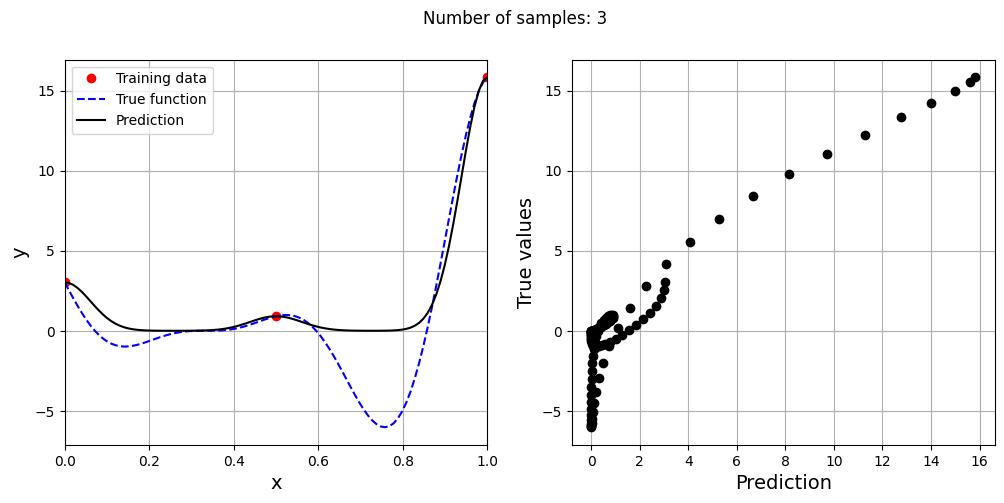

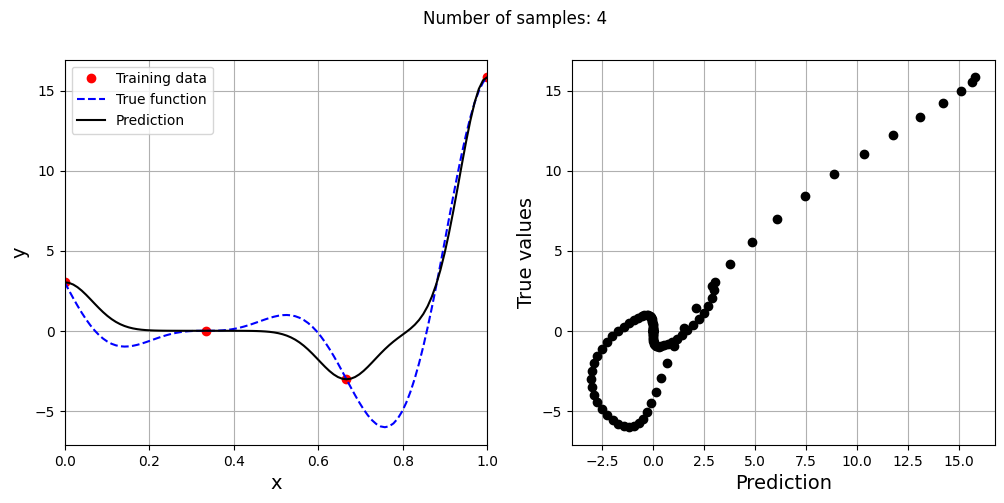

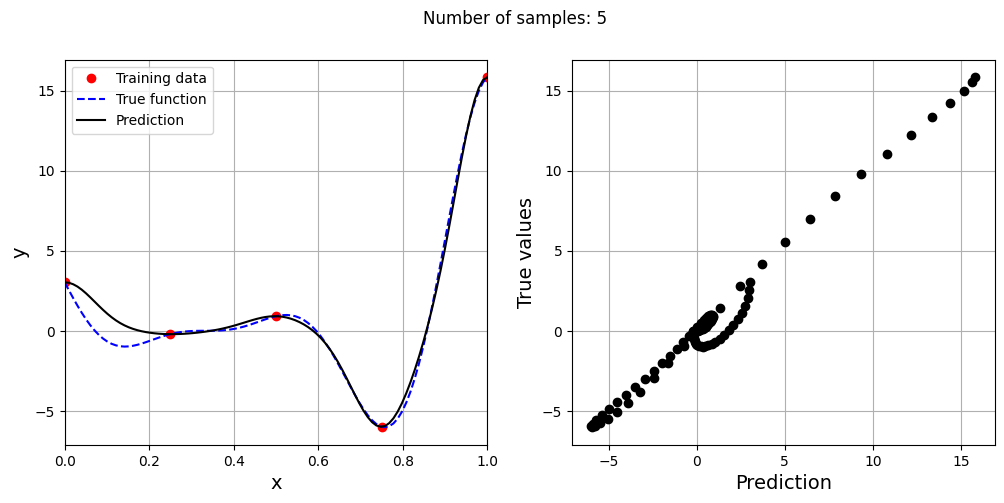

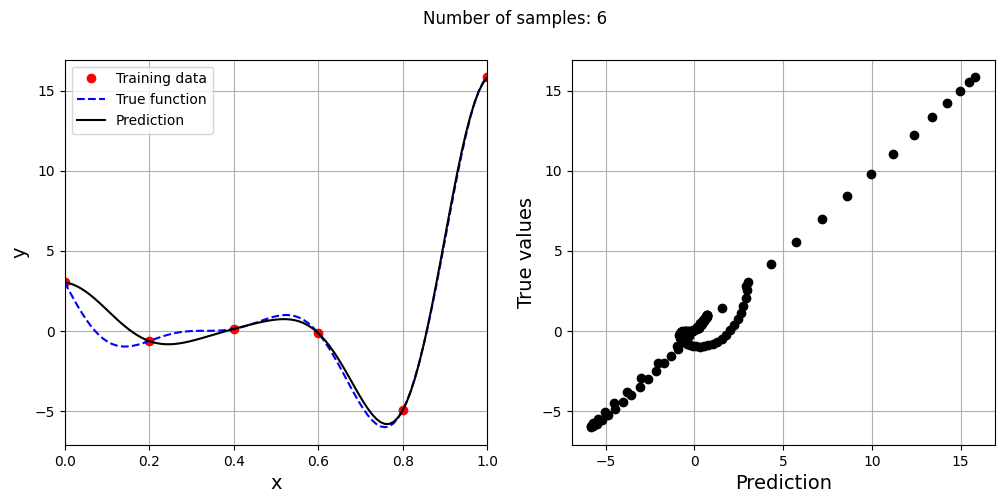

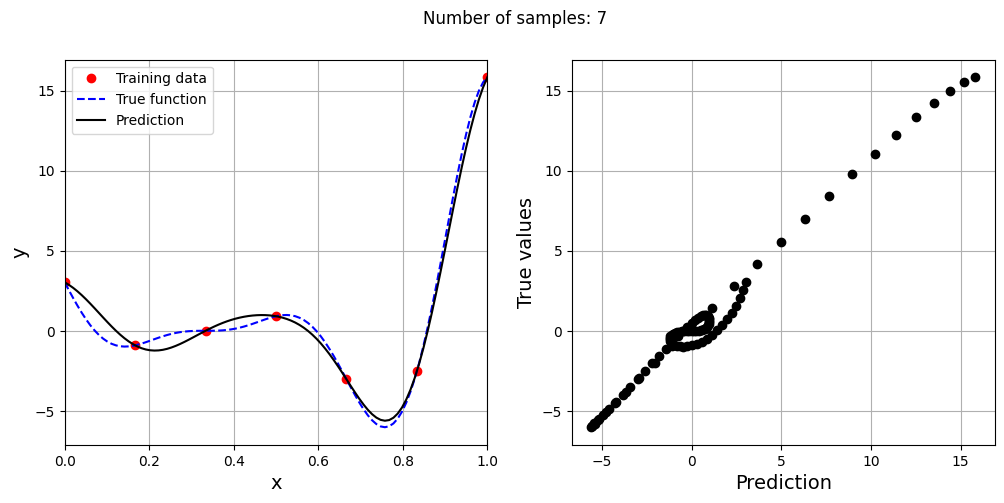

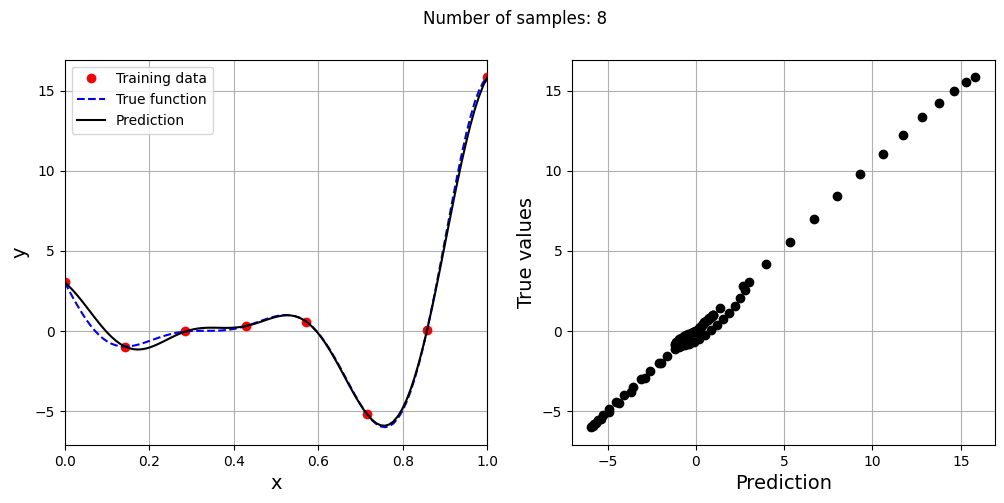

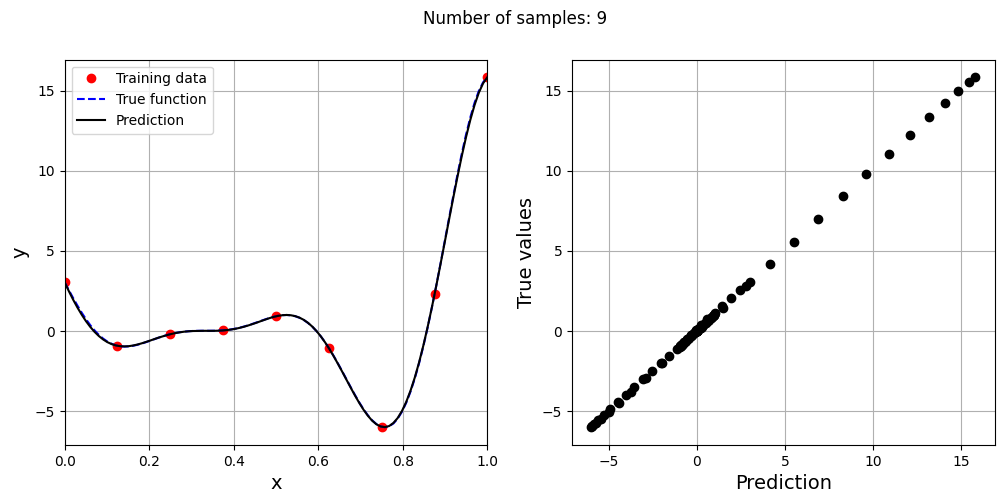

In [16]:
# Creating array of training sample sizes
samples = np.array([3, 4, 5, 6, 7, 8, 9])

# Initializing nrmse list
nrmse = []

sigmas = np.logspace(-2, 1, 100)

# Fitting with different sample size
for sample in samples:
    
    x_train = torch.linspace(xlower, xupper, sample)
    y_train = forrester(x_train)
    
    best_sigma, _ = find_sigma(x_train, y_train, x_test, y_test, sigmas)

    print("Best sigma value for {} samples: {}".format(sample, best_sigma))
    
    # Fitting the RBF
    rbf = RBF(x_train=x_train.reshape(-1,1), y_train=y_train.reshape(-1,1), sigma=best_sigma.item(), basis="gaussian")
    rbf_weights, basis_matrix = rbf.fit()

    # Predict at test values
    y_test_pred = rbf.predict(x_test.reshape(-1,1))

    # Calculating average nrmse
    nrmse.append( evaluate_scalar(y_test, y_test_pred.reshape(-1,), metric="nrmse") )
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(x_train, y_train, "ro", label="Training data")
    ax[0].plot(x_test, y_test, "b--", label="True function")
    ax[0].plot(x_test, y_test_pred, "k", label="Prediction")
    ax[0].set_xlim((xlower, xupper))
    ax[0].set_xlabel("x", fontsize=14)
    ax[0].set_ylabel("y", fontsize=14)
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(y_test_pred, y_test, 'ko')
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

As the number of samples increase, the model prediction becomes better. Also, note that the value of best $\sigma$ changes with number of samples. So, it is important to change the hyperparameters when model is retrained with different data. Below block of code plots the normalized rmse as a function of number of samples. The nrmse decreases as the number of samples increase since prediction improves.

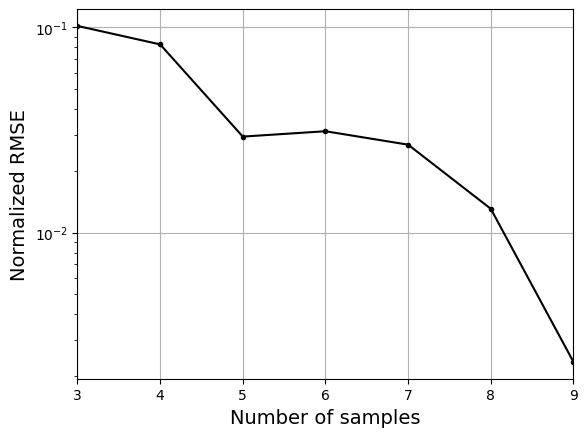

In [17]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), 'k', marker='.')
ax.grid()
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)
ax.set_yscale("log")